# Нормально знакомимся с PyTorch

Познакомимся с фреймворком машинного обучения PyTorch
Обучим полносвязную нейронную сеть для классификации 3 классов изображений из набора данных CIFAR100

# Библиотеки:

* __np__ - библиотека NumPy для работы с многомерными массивами данных
* __pickle__ - библиотека Pickle для сериализации и десериализации структур данных ЯП Python
* __sklearn__ - библиотека, реализующая в основном методы классического машинного обучения и инструменты для работы с ними
* __PIL__ - легковесная библиотека Pillow для работы с изображениями и вывода графических элементов напрямую в Jupyter Notebook
* __matplotlib__ - библиотека для построения графиков, по большей части повторяет API Matlab'a
* __torch__ - библиотека Pytorch для глубокого обучения нейронных сетей

* __torch.Tensor__ - cоздает тензор из многомерного массива Numpy и наследует его тип данных. По умолчанию память под тензоры выделяется на CPU. При выставлении флага __requires_grad__ автоматически отслеживает градиенты с помощью движка autograd, который строит динамический вычислительный граф. Включить отслеживания тензора __t__ можно так же при помощи метода __t.requires_grad_(True)__. В таком случае после вызова метода __backward__, в поле __grad__ будут записаны производные. Производные тензора __t__ можно очистить вызовом метода __t.grad.zero_()__. Для того чтобы отсечь ненужные вычисления производных используется метод __detach__, который создаёт копию тензора, при этом флаг __requires_grad__ снимается и отслеживание движком autograd прекращается.

* __torch.numpy__ - создает многомерный NumPy массив данных из тензора

* __torch.item__ - возвращает число, но только если ранг тензора 0. В противном случае выдаёт ошибку и следует использовать torch.numpy

* __torch.uint8__, __torch.int16__, __torch.int64__, __torch.float32__ - приведение массива к новому типу, аналогично NumPy. Для приведения используется метод .to (например `t.to(torch.int64)`). По умолчанию все вычисления на графе производятся в float64, есть также возможность использования mixed precision (что-то во float16, что-то во float64), но это считается продвинутой техникой.

* __torch.ones__, __torch.zeros__, __torch.transpose__, __torch.reshape__ - API похожий, как у NumPy

* __torch.rand__ - создание случайного тензора с числами в диапазоне от 0 до 1. Размерность перечисляется через запятую

* __torch.t__ - транспонирование тензора, похоже на рассмотренный ранее __numpy.transpose__. Если дан тензор X, то можно его транспонировать при помощи `X.t()`

* __torch.sum__ - суммирование элементов тензора вдоль указанной оси __axis__. Если суммирование производится вдоль последней оси, то разрешается указать вместо номера -1. Для сохранения исходной размерности тензора, необходимо выставить флаг __keepdims__.

* __torch.maximum__ - производит поэлементное сравнение тензоров и возвращает максимальный из элементов. На практике используется для реализации некоторых функций активации нейронной сети

* __torch.mm__ - произведение тензоров. Для 2 двухмерных матриц с размерностями (M, N) и (N, K) результатом данного метода будет двухмерная матрица размерностью (M, K)

* __torch.exp__ - повторяет функционал __numpy.exp__ - поэлементное возведение тензора в степень экспоненты

* __torch.log__ - поэлементная операция логарифмирования тензора - взятие натурального логарифма, обратная операция потенциирования

* __torch.flatten__ - аналогично NumPy .reshape(-1), если указан параметр start_dim, то начинает "выпрямление" массива начиная с указанного номера. Т.е. для того, чтобы перевести тензор t с формой (100, 32, 32, 3) в форму (100, 3072) достаточно написать `torch.flatten(t, start_dim=1)`

* __F.one_hot__ - один из многих способов получить горячую кодировку класса в виде PyTorch тензора. Например, для 5 классов, горячая кодировка класса "4" будет [0, 0, 0, 1, 0]

* __torch.utils.data.TensorDataset__ - создание связанных тензоров, например обучающих примеров и соответствующих меток. В качестве аргумента передаются тензоры. Приемлемый способ создания набора данных, когда обучающая выборка некрупная и полностью помещается в оперативной памяти.

* __torch.utils.data.DataLoader__ - В основе утилиты загрузки данных PyTorch лежит класс DataLoader. Он представляет собой Python объект, повторяющийся по набору данных, с поддержкой набора данных в стиле map и итератора; настройки порядка загрузки данных; автоматического разбиения на минибатчи;загрузки данных в один и несколько процессов/потоков. Самые полезные аргументы в конструкторе - размер мини-батча __batch_size__ и число параллельных процессов __num_workers__. Чтобы перемешать данные (для лучшей сходимости), следует выставить флаг __shuffle__ в True

* __torch.save__ - сохранение параметров модели на постоянный носитель информации. Для этого первым аргументом передаётся model.state_dict(), где model - обученная нейросетевая модель, а вторым аргументов передаётся путь с именем файла.

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.metrics import classification_report
from PIL import Image
%matplotlib inline

# Классификация изображений CIFAR100

Cifar100 - набор данных,состоящий из цветных изображений (3 цвета) 100 классов.
Размер набора 32 на 32 пикселя.

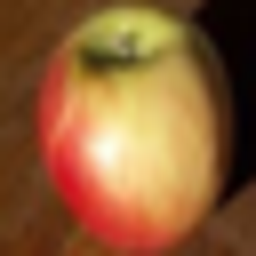

In [3]:
# Чтение тренировочной выборки (обучающих данных)
with open('Datasets/CIFAR100/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')

# Чтение тестовой выборки (тестовых данных)
with open('Datasets/CIFAR100/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Выберем три класса
CLASSES = [0, 55, 58]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1])  # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256, 256))

## Создание Pytorch DataLoader'a

Батч - количество изображений (часть датасета), на которых модель обучается за одну итерацию.  
Пример:  
Датасет - 1000 изображений. Батч - 100 изображений. Значит, весь дата сет обучится за 10 итераций.

In [4]:
# Указываем размер батча
batch_size = 128

dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                         num_classes=len(CLASSES)) / 1.
    dataset = TensorDataset(tensor_x, tensor_y)  # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x2250cc62190>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x2250cad6490>}

# Создание модели

Создание моделей осуществляется при помощи модуля nn, при этом в модуле уже реализованы самые популярные блоки нейронных сетей или слои, такие как:
* полносвязный слов Linear
* свёрточный слой Conv2d
* пуллинг MaxPool2d
* нормализация BatchNorm2d
* множество активационных функций ReLU, Softmax, Tanh
* слои-регуляризаторы, например Dropout

Задать модель можно 2 способам:
1. при помощи nn.Sequential
2. при помощи наследования от класса nn.Module

Первый способ подходит для создания простых моделей без ответвлений. По сути их можно представить как конвейер, где входной тензор передается ряду последовательно приведённых трансформаций для получения выходного тензора.

Если необходимо применять более сложные архитектуры, где конвейерные дорожки могут разветвляться на несколько частей, то используется nn.Module. Данный подход позволяет реализовать самые разные архитектуры.

Для создания простого многослойного перцептрона с одним скрытым слоем и функцией нелинейности, согласно первому способу достаточно написать следующий код:

    model = nn.Sequential(
      nn.Linear(input_dims, hidden_dims),
      nn.ReLU(),
      nn.Linear(hidden_dims, num_classes)
    )

Для создания простого многослойного перцептрона с одним скрытым слоем и функцией нелинейности, согласно второму способу необходимо создать класс и модель как экземпляр этого класса:

    class MLP(nn.Module):
        def __init__(self, input_dims, hidden_dims, num_classes,
                     *args, **kwargs):
            super(MLP, self).__init__()
            self.fc1 = Linear(input_dims, hidden_dims)
            self.fc2 = Linear(hidden_dims, num_classes)
        
        def forward(self, input):
             x = self.fc1(input)
             x = F.relu(x)
             x = self.fc2(x)
             return x
    
    model = MLP(input_dims, hidden_dims, num_classes)

При этом допускается вкладывать nn.Module и nn.Sequential внутри других модулей, что позволяет создавать очень сложные архитектуры моделей.

## Создание Pytorch модели многослойного перцептрона с одним скрытым слоем

In [6]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1)  # nhwc -> nm


# Создадим простой многослойный перцептрон с одним скрытым слоем и функцией нелинейности.
# Количество скрытых слоев можно изменять.
class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        self.norm = Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32 * 32 * 3, hidden_size),
            nn.ReLU(),  # активационная функция
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)


HIDDEN_SIZE = 10
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

# Обучение моделей

Перед обучением моделей необходимо выбрать функцию потерь и оптимизатор. Различные функции потерь представлены также в модуле nn:
* __nn.MSELoss__ - среднеквадратическая ошибка (y_true-y_pred)**2
* __nn.BCEWithLogitsLoss__ - бинарная перекрёстная энтропия для задач бинарной классификации
* __nn.CrossEntropyLoss__ - категориальная перекрёстная энтропия для задач многоклассовой классификации

В качестве альтернативы можно собственноручно реализовать функцию потерь, например для MSELoss:

    inputs, y = batch
    ...
    output = model(inputs)
    loss = ((output - y)**2).sum()
    ...

Оптимизаторы содержатся в модуле __torch.optim__. Существует множество оптимизаторов целевой функции, классическим является стохастический градиентный спуск Stochastic Gradient Descent или SGD. В конструктор класса необходимо передать веса модели, а также указать шаг обучения или learning rate.

## Выбор функции потерь и оптимизатора градиентного спуска

In [7]:
# Функция потерь
criterion = nn.CrossEntropyLoss()
# Оптимизатор
# lr - шаг обучения. Данный параметр можно изменять.
optimizer = optim.SGD(model.parameters(), lr=0.005)

## Обучение модели по эпохам

Для перевода модели в состояние обучения необходимо вызвать метод __train__. После чего модель готова для обучения.
Для обучения нейросетевых моделей используется градиентный спуск и его разновидности, в основе которых лежит метод последовательных приближений.
За одну эпоху условно выбирают прохождение итератора через весь набор данных, за одну итерацию - оптимизация параметров модели с помощью текущего мини-батча. PyTorch автоматически считает производные при вызове метода __backward__, применённому к функции потерь.
При этом при повторном вызове, значения новых градиентов добавятся к предыдущим расчитанным. Поэтому, для избежания нежелательных эффектов принято очищать прошлые значения градиентов на каждой итерации при помощи метода __zero_grad__, применённого к экземпляру класса оптимизатора.

Эпоха – обход всех экземпляров набора данных.  
Итерация - один шаг обучения.  
Переобучение (overfitting) – Модель, которая хорошо работает на обучающих данных и плохо на тестовых данных.

In [8]:
# Укажем количество эпох.
# Увеличение количества эпох приводит к увеличению времени работы программы.
# Чем больше эпох мы обучаем, тем точнее обучается модель, но есть риск наступления переобучения.

EPOCHS = 250
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()

        #Для обновления параметров нейронной сети используется метод step, применённый к экземпляру класса оптимизатора.
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    running_loss = 0.0

    #Для перевода модели в состояние проверки необходимо вызвать метод eval. После чего модель готова для проверки.
    model.eval()

    with torch.no_grad():  # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение завершено')

[1,    12] loss: 0.996
[1,     3] val loss: 0.906
[2,    12] loss: 0.822
[2,     3] val loss: 0.810
[3,    12] loss: 0.748
[3,     3] val loss: 0.788
[4,    12] loss: 0.701
[4,     3] val loss: 0.733
[5,    12] loss: 0.666
[5,     3] val loss: 0.728
[6,    12] loss: 0.640
[6,     3] val loss: 0.733
[7,    12] loss: 0.617
[7,     3] val loss: 0.683
[8,    12] loss: 0.597
[8,     3] val loss: 0.731
[9,    12] loss: 0.579
[9,     3] val loss: 0.652
[10,    12] loss: 0.564
[10,     3] val loss: 0.665
[11,    12] loss: 0.550
[11,     3] val loss: 0.625
[12,    12] loss: 0.535
[12,     3] val loss: 0.643
[13,    12] loss: 0.522
[13,     3] val loss: 0.628
[14,    12] loss: 0.513
[14,     3] val loss: 0.601
[15,    12] loss: 0.504
[15,     3] val loss: 0.612
[16,    12] loss: 0.492
[16,     3] val loss: 0.606
[17,    12] loss: 0.481
[17,     3] val loss: 0.616
[18,    12] loss: 0.471
[18,     3] val loss: 0.599
[19,    12] loss: 0.462
[19,     3] val loss: 0.638
[20,    12] loss: 0.455
[20,  

## Проверка качества модели по классам на обучающей и тестовой выборках

**Метрики качества:**
– Точность (Precision) – Процент положительных меток, которые правильно определены  
  *Precision = (# true positives) / (# true positives + # false positives)*  
– Полнота (Recall) – Процент положительных примеров, которые были правильно определены  
  *Recall = (# true positives) / (# true positives + # false negatives)*  
– Accuracy – Процент положительных меток  
  *Accuracy = (# true positives + # true negatives) / (# of samples)*

In [9]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad():  # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)

        # Выведем отчет о точности обучения модели.
        # На тестовых данных модель может обучиться до 100%. Результ, который показывается на тренировочной выборке, хуже.

        # Выведем метрики ранжирования для тестовой и обучающей выборки.
        print(part)

        # Значения выводятся с точность 4 знака после запятой.

        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-' * 50)

train
              precision    recall  f1-score   support

           0     1.0000    0.9960    0.9980       500
          55     0.9921    1.0000    0.9960       500
          58     1.0000    0.9960    0.9980       500

    accuracy                         0.9973      1500
   macro avg     0.9974    0.9973    0.9973      1500
weighted avg     0.9974    0.9973    0.9973      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

           0     0.8230    0.9300    0.8732       100
          55     0.7087    0.7300    0.7192       100
          58     0.7619    0.6400    0.6957       100

    accuracy                         0.7667       300
   macro avg     0.7646    0.7667    0.7627       300
weighted avg     0.7646    0.7667    0.7627       300

--------------------------------------------------


# Сохранение модели в ONNX

Рассмотрим два способа сохранения модели:
1.   Сохранение параметров
2.   Сохранение всей архитектуры

In [10]:
# Сохранение параметров
PATH = 'cifar_lnn.pth'
torch.save(model.state_dict(), PATH)
# загрузка
new_model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
new_model.load_state_dict(torch.load(PATH))
new_model.eval()

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [11]:
# Сохранение всей архитектуры
PATH2 = 'cifar_lnn.pt'
torch.save(model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval()

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [12]:
!pip install onnx

     ---------------------------------------- 14.3/14.3 MB 3.3 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to('cpu')
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,  # модель
                  x,  # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_LNN.onnx",  # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,  # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names=['input'],  # имя входного слоя
                  output_names=['output'],  # имя выходного слоя
                  dynamic_axes={'input': {0: 'batch_size'},  # динамичные оси, в данном случае только размер пакета
                                'output': {0: 'batch_size'}})

Модель сохраняется в файлах с расширением .onnx. Этот файл можно скачать к себе и использовать для дальнейшей загрузки и использования обученнной модели.